In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import yaml
import pandas as pd
import numpy as np
from functools import partial
import multiprocessing
import tensorflow as tf
from pathlib import Path
from time import strftime, time
from shutil import rmtree
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
#matplotlib.use("TKAgg", force=True)
%matplotlib inline
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
from rtapipe.lib.utils.misc import dotdict
from rtapipe.lib.dataset.data_manager import DataManager
from rtapipe.lib.datasource.Photometry3 import OnlinePhotometry, SimulationParams
from rtapipe.lib.plotting.plotting import plot_sequences, plot_nn_metrics
from rtapipe.lib.models.anomaly_detector_builder import AnomalyDetectorBuilder
from rtapipe.lib.evaluation.pval import get_pval_table, get_threshold_for_sigma
from rtapipe.lib.standardanalysis.li_ma import LiMa
from rtapipe.lib.evaluation.pval import get_pval_table, get_threshold_for_sigma, get_sigma_from_pvalue, get_sigma_for_ts_array, get_sigma_from_ts
from rtapipe.lib.utils.notebook import *
from sagsci.tools.utils import get_obs_pointing
from sagsci.wrappers.rtaph.photometry import Photometrics
from rtapipe.lib.utils.notebook import *

# Loading the models

In [3]:
def load_model(model_id):
    with open("./trained_models.yaml", "r") as f:
        try:
            configs = yaml.safe_load(f)
        except yaml.YAMLError as exc:
            print(exc)
    model_config = [c for c in configs["models"] if c["id"] == model_id]
    model_config = dotdict(model_config.pop())
    model_config.ad = AnomalyDetectorBuilder.getAnomalyDetector(name=model_config.name, timesteps=model_config.timesteps, nfeatures=model_config.nfeatures, load_model="True", training_epoch_dir=model_config.path, training=False)
    model_config.pvalue_table = get_pval_table(model_config.pval_path) 
    return model_config

In [4]:
model_config_cnn = load_model(0)
model_config_cnn

AnomalyDetector_cnn_l2_u32 - input shape: (5,3)


{'id': 0,
 'patience': 5,
 'integrationtime': 5,
 'timesteps': 5,
 'nfeatures': 3,
 'scaler': 'minmax',
 'name': 'AnomalyDetector_cnn_l2_u32',
 'path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_19',
 'epoch': 19,
 'pval_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_19/pvalues/pval_20221118-113940/pvalue_bins_100_0.numpy.txt',
 'scaler_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/fitted_scaler.pickle',
 'ad': <rtapipe.lib.models.anomaly_detector_cnn.AnomalyDetector_cnn_l2_u32 at 0x2aae01d95df0>,
 'pvalue_table':     threshold  threshold_err        pvalue    pvalue_err  sigma
 0    0.003171       0.000

In [5]:
model_config_cnn.ad.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 32)             320       
_________________________________________________________________
dropout (Dropout)            (None, 3, 32)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 32)             0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 5, 3)              291       
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 3)              0         
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________


In [6]:
model_config_rnn = load_model(1)
model_config_rnn

AnomalyDetector_rnn_l2_u32 - input shape: (5,3)


{'id': 1,
 'patience': 5,
 'integrationtime': 5,
 'timesteps': 5,
 'nfeatures': 3,
 'scaler': 'minmax',
 'name': 'AnomalyDetector_rnn_l2_u32',
 'path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_10',
 'epoch': 10,
 'pval_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_10/pvalues/pval_20221121-132236/pvalue_bins_100_0.numpy.txt',
 'scaler_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/fitted_scaler.pickle',
 'ad': <rtapipe.lib.models.anomaly_detector_rnn.AnomalyDetector_rnn_l2_u32 at 0x2aaf2f3380a0>,
 'pvalue_table':     threshold  threshold_err        pvalue    pvalue_err  sigma
 0    0.000227       0.000

In [7]:
model_config_rnn.ad.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1152      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 32)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 5, 32)             2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 3)              99        
Total params: 3,331
Trainable params: 3,331
Non-trainable params: 0
____________________________________________________

# Loading the test dataset

In [8]:
output_dir = "./logs/test_models_dataset_test_set_all_itime_5"

In [9]:
features_names = ["EB_0.04-0.117","EB_2-0.117-0.342","EB_0.342-1"]

In [10]:
data_manager = DataManager(output_dir)

In [11]:
dataset_folder = "/data01/homes/baroncelli/phd/rtapipe/scripts/ml/dataset_generation/test/test_set_all/fits_data"
fits_files = DataManager.load_fits_data(dataset_folder, limit=500)
test_set_size = len(fits_files)

Loaded 419 files


In [12]:
sim_params = SimulationParams(runid=None, onset=250, emin=0.04, emax=1, tmin=0, tobs=500, offset=0.5, irf="North_z40_5h_LST", roi=2.5, caldb="prod5-v0.1", simtype="grb")
multiple_templates = True
add_target_region = True
integration_time = 5
number_of_energy_bins = 3
tsl = 100
threads = 30
normalize = True
#data_manager.transform_to_timeseries(fits_files, sim_params, add_target_region, integration_time=integration_time, number_of_energy_bins=number_of_energy_bins, tsl=tsl, normalize=normalize, threads=threads, multiple_templates=multiple_templates)
data_manager.load_saved_data(5, 100)

[2023-01-28 11:49:07.324058] Loaded data from logs/test_models_dataset_test_set_all_itime_5/data_cache. Loaded 419 templates.


In [13]:
assert len(data_manager.data) == test_set_size

## Plot some samples

In [14]:
#for template in list(data_manager.data.keys())[0:5]:
#    data_manager.plot_timeseries(template, data_manager.data[template], 1, sim_params, output_dir, labels=features_names)

# TESTING

In [15]:
data_manager.load_scaler(model_config_rnn.scaler_path) # model_config_rnn.scaler_path or model_config_cnn.scaler_path

In [16]:
test_all_x, test_all_y = data_manager.get_test_set_all_templates(verbose=False, onset=250, integration_time=integration_time, sub_window_size=5, stride=1)

[2023-01-28 11:49:07.563080] Total x shape shape: (40224, 5, 3)
[2023-01-28 11:49:07.563131] Total y shape shape: (40224,)


In [17]:
test_all_y.sum()

20531

# P-value tables

## RNN

In [18]:
tmpdf=model_config_rnn.pvalue_table.drop(["threshold_err"], axis=1)
tmpdf

threshold        pvalue    pvalue_err  sigma
0    0.000227  1.416930e-01  1.254772e-04  1.073
1    0.000253  9.859137e-02  1.046671e-04  1.290
2    0.000279  6.802256e-02  8.693953e-05  1.491
3    0.000305  4.666059e-02  7.200554e-05  1.678
4    0.000331  3.223601e-02  5.984963e-05  1.849
..        ...           ...           ...    ...
87   0.002495  1.111173e-07  1.111173e-07  5.180
88   0.002521  1.111173e-07  1.111173e-07  5.180
89   0.002547  1.111173e-07  1.111173e-07  5.180
90   0.002574  1.111173e-07  1.111173e-07  5.180
91   0.002600  1.111173e-07  1.111173e-07  5.180

[92 rows x 4 columns]

In [19]:
tmpdf=model_config_rnn.pvalue_table.drop_duplicates(subset=['sigma'])
tmpdf=model_config_rnn.pvalue_table.drop(["threshold_err"], axis=1)

tmpdf=tmpdf.loc[
    (tmpdf['sigma'] > 0.99)   & 
    (tmpdf['sigma'] < 1.1) |
    (tmpdf['sigma'] > 1.4) &
    (tmpdf['sigma'] < 1.6) |
    (tmpdf['sigma'] > 1.9) &
    (tmpdf['sigma'] < 2.1) |
    (tmpdf['sigma'] > 2.4) &
    (tmpdf['sigma'] < 2.6) |
    (tmpdf['sigma'] > 2.9) &
    (tmpdf['sigma'] < 3.1) |
    (tmpdf['sigma'] > 3.4) &
    (tmpdf['sigma'] < 3.6) |
    (tmpdf['sigma'] > 3.9) &
    (tmpdf['sigma'] < 4.1) |
    (tmpdf['sigma'] > 4.4) &
    (tmpdf['sigma'] < 4.6) | 
    (tmpdf['sigma'] > 4.9) &
    (tmpdf['sigma'] < 5.1) 
]


tmpdf.to_latex("pvalue_table_rnn.tex")
! cat pvalue_table.tex

\begin{tabular}{lrrrr}
\toprule
{} &  threshold &        pvalue &    pvalue\_err &  sigma \\
\midrule
0  &   0.003171 &  1.283972e-01 &  1.201785e-04 &  1.134 \\
4  &   0.003751 &  6.115264e-02 &  8.293861e-05 &  1.545 \\
9  &   0.004476 &  2.277199e-02 &  5.061155e-05 &  2.000 \\
16 &   0.005492 &  5.323285e-03 &  2.447028e-05 &  2.554 \\
23 &   0.006507 &  1.228234e-03 &  1.175411e-05 &  3.029 \\
31 &   0.007667 &  2.312711e-04 &  5.100465e-06 &  3.502 \\
41 &   0.009118 &  3.149606e-05 &  1.882250e-06 &  4.001 \\
53 &   0.010859 &  3.262092e-06 &  6.057553e-07 &  4.509 \\
73 &   0.013760 &  4.499438e-07 &  2.249719e-07 &  4.912 \\
74 &   0.013905 &  2.249719e-07 &  1.590791e-07 &  5.047 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_220255/1959280081.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tmpdf.to_latex("pvalue_table_rnn.tex")


## CNN

In [20]:
tmpdf=model_config_cnn.pvalue_table.drop_duplicates(subset=['sigma'])
tmpdf=model_config_cnn.pvalue_table.drop(["threshold_err"], axis=1)

tmpdf=tmpdf.loc[
    (tmpdf['sigma'] > 1)   & 
    (tmpdf['sigma'] < 1.2) |
    (tmpdf['sigma'] > 1.45) &
    (tmpdf['sigma'] < 1.6) |
    (tmpdf['sigma'] > 1.95) &
    (tmpdf['sigma'] < 2.084) |
    (tmpdf['sigma'] > 2.481) &
    (tmpdf['sigma'] < 2.6) |
    (tmpdf['sigma'] > 2.97) &
    (tmpdf['sigma'] < 3.09) |
    (tmpdf['sigma'] > 3.49) &
    (tmpdf['sigma'] < 3.555) |
    (tmpdf['sigma'] > 3.961) &
    (tmpdf['sigma'] < 4.051) |
    (tmpdf['sigma'] > 4.463) &
    (tmpdf['sigma'] < 4.51) | 
    (tmpdf['sigma'] > 4.9) &
    (tmpdf['sigma'] < 5.048) 
]


tmpdf.to_latex("pvalue_table_cnn.tex")
! cat pvalue_table.tex

/tmp/ipykernel_220255/1294718993.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tmpdf.to_latex("pvalue_table_cnn.tex")


\begin{tabular}{lrrrr}
\toprule
{} &  threshold &        pvalue &    pvalue\_err &  sigma \\
\midrule
0  &   0.003171 &  1.283972e-01 &  1.201785e-04 &  1.134 \\
4  &   0.003751 &  6.115264e-02 &  8.293861e-05 &  1.545 \\
9  &   0.004476 &  2.277199e-02 &  5.061155e-05 &  2.000 \\
16 &   0.005492 &  5.323285e-03 &  2.447028e-05 &  2.554 \\
23 &   0.006507 &  1.228234e-03 &  1.175411e-05 &  3.029 \\
31 &   0.007667 &  2.312711e-04 &  5.100465e-06 &  3.502 \\
41 &   0.009118 &  3.149606e-05 &  1.882250e-06 &  4.001 \\
53 &   0.010859 &  3.262092e-06 &  6.057553e-07 &  4.509 \\
73 &   0.013760 &  4.499438e-07 &  2.249719e-07 &  4.912 \\
74 &   0.013905 &  2.249719e-07 &  1.590791e-07 &  5.047 \\
\bottomrule
\end{tabular}


# RNN

## Evaluate metrics for different trehsholds

In [21]:
metrics_rnn = evaluate_metrics(model_config_rnn, test_all_x, test_all_y, output_dir, "metrics_rnn.pickle", additional_tresholds=[0.000025, 0.000050, 0.000075])

Loading metrics_rnn.pickle from logs/test_models_dataset_test_set_all_itime_5/metrics_rnn.pickle...


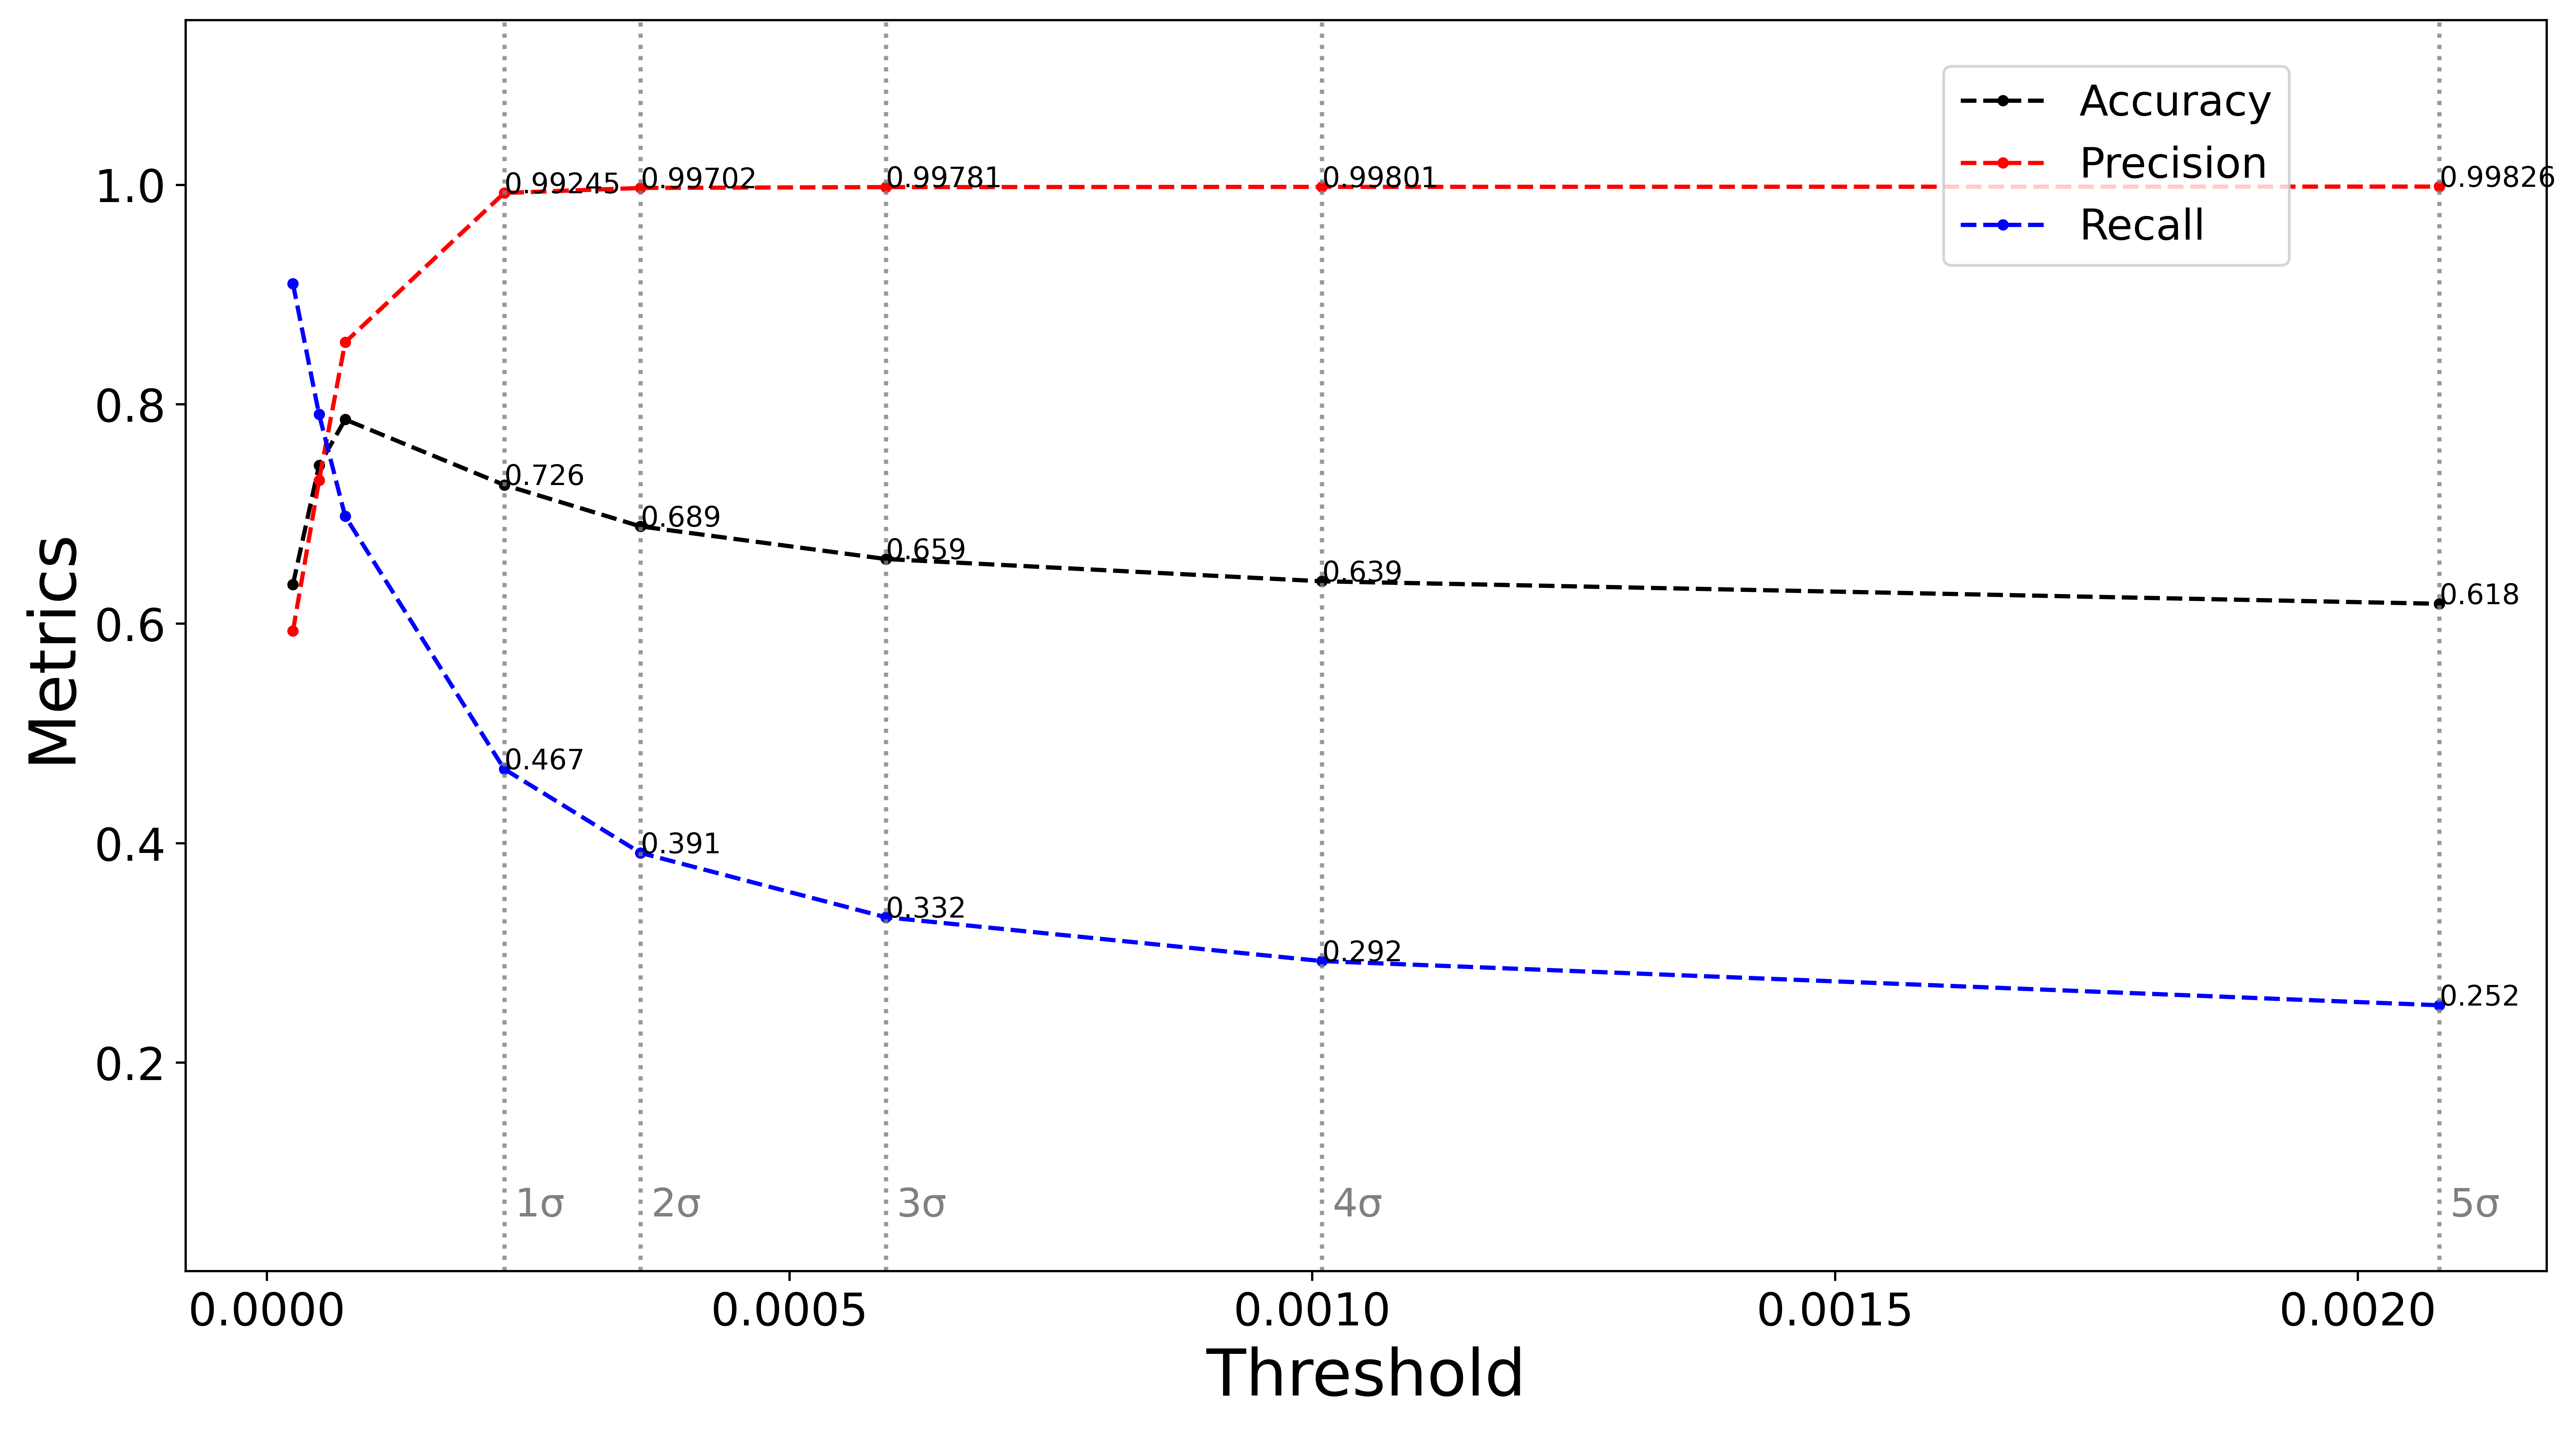

Saved figure to:  logs/test_models_dataset_test_set_all_itime_5/rnn_metrics_test_set_all_itime_5.png


In [22]:
%matplotlib inline
plot_nn_metrics(metrics_rnn, model_config_rnn, output_dir, fig_name="rnn_metrics_test_set_all_itime_5", y_lim=(0.01, 1.15), annotate_after=3, showFig=True, saveFig=True)

## Standard metrics - 5 sigma threshold

In [23]:
SIGMA_THRESHOLD = 5

In [24]:
sigma_threshold = get_threshold_for_sigma(model_config_rnn.pvalue_table, SIGMA_THRESHOLD)
model_config_rnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_rnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_rnn.pvalue_table, model_config_rnn.ad.threshold)} sigma")

Threshold: 0.0020782086315 corresponding to 5.0488536162 sigma


In [25]:
print(f"************** Evaluating {model_config_rnn.name} patience={model_config_rnn.patience} **************")
metrics = model_config_rnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_rnn.ad.detection_delay(test_all_y, model_config_rnn.ad.predict(test_all_x), test_set_size, model_config_rnn.timesteps))

************** Evaluating AnomalyDetector_rnn_l2_u32 patience=5 **************
Using threshold 0.0020782086315
accuracy 0.6180887032617343
precision 0.9982648930017352
recall 0.25220398421898593
f1 0.402675169142235
roc_auc 0.6258734845179631
confusion_matrix [[19684, 9], [15353, 5178]]
false_positive_rate 0.001735106998264893
detection_delay: 2.4463007159904535


## Sigma table

In [26]:
def crop_to_5(s):
    if s > 5: 
        s = 5.00001
    return s

In [27]:
data = {}
for template in tqdm(list(data_manager.data.keys())):
    test_x, test_y = data_manager.get_test_set(template=template, onset=250, integration_time=5, sub_window_size=5, stride=1)
    model_config_rnn.ad.predict(test_x)
    data[template] = get_sigma_for_ts_array(model_config_rnn.pvalue_table, model_config_rnn.ad.get_reconstruction_errors(), verbose=False)

sigma_table_rnn = pd.DataFrame(data, index=DataManager.get_tbin_of_sequences(96, 5, 5, 1))    
sigma_table_rnn = sigma_table_rnn.applymap(crop_to_5)

100%|██████████| 419/419 [00:24<00:00, 17.23it/s]


In [28]:
sigma_table_rnn

run0002_ID000044  run0005_ID000225  run0009_ID000191  \
0-25                  0.0          0.000000          0.000000   
5-30                  0.0          0.000000          0.000000   
10-35                 0.0          0.000000          0.000000   
15-40                 0.0          0.000000          0.000000   
20-45                 0.0          0.000000          0.000000   
...                   ...               ...               ...   
455-480               0.0          3.340322          0.000000   
460-485               0.0          3.123477          0.000000   
465-490               0.0          0.000000          0.000000   
470-495               0.0          0.000000          1.719958   
475-500               0.0          0.000000          0.000000   

         run0011_ID000139  run0013_ID000321  run0016_ID000340  \
0-25                    0          0.000000                 0   
5-30                    0          0.000000                 0   
10-35                   0          0.000000                 0   
15-40                   0          0.000000                 0   
20-45                   0          0.000000                 0   
...                   ...               ...               ...   
455-480                 0          0.000000                 0   
460-485                 0          0.000000                 0   
465-490                 0          0.000000                 0   
470-495                 0          0.000000                 0   
475-500                 0          1.197792                 0   

         run0017_ID000132  run0017_ID000261  run0017_ID000302  \
0-25                  0.0          0.000000               0.0   
5-30                  0.0          0.000000               0.0   
10-35                 0.0          0.000000               0.0   
15-40                 0.0          0.000000               0.0   
20-45                 0.0          0.000000               0.0   
...                   ...               ...               ...   
455-480               0.0          4.297206               0.0   
460-485               0.0          4.224088               0.0   
465-490               0.0          4.190291               0.0   
470-495               0.0          3.969708               0.0   
475-500               0.0          3.544812               0.0   

         run0019_ID000070  run0019_ID000268  run0019_ID000338  \
0-25              0.00000           0.00000                 0   
5-30              0.00000           0.00000                 0   
10-35             0.00000           0.00000                 0   
15-40             0.00000           0.00000                 0   
20-45             0.00000           0.00000                 0   
...                   ...               ...               ...   
455-480           5.00001           5.00001                 0   
460-485           5.00001           5.00001                 0   
465-490           5.00001           5.00001                 0   
470-495           5.00001           5.00001                 0   
475-500           5.00001           4.97082                 0   

         run0021_ID000373  run0023_ID000267  run0025_ID000471  \
0-25                    0               0.0          0.000000   
5-30                    0               0.0          0.000000   
10-35                   0               0.0          1.543997   
15-40                   0               0.0          0.000000   
20-45                   0               0.0          0.000000   
...                   ...               ...               ...   
455-480                 0               0.0          0.000000   
460-485                 0               0.0          0.000000   
465-490                 0               0.0          1.425664   
470-495                 0               0.0          0.000000   
475-500                 0               0.0          0.000000   

         run0026_ID000127  run0027_ID000288  run0029_ID000397  \
0-25                    0              

# CNN

In [29]:
metrics_cnn = evaluate_metrics(model_config_cnn, test_all_x, test_all_y, output_dir, "metrics_cnn.pickle", additional_tresholds=[0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.002])

Loading metrics_cnn.pickle from logs/test_models_dataset_test_set_all_itime_5/metrics_cnn.pickle...


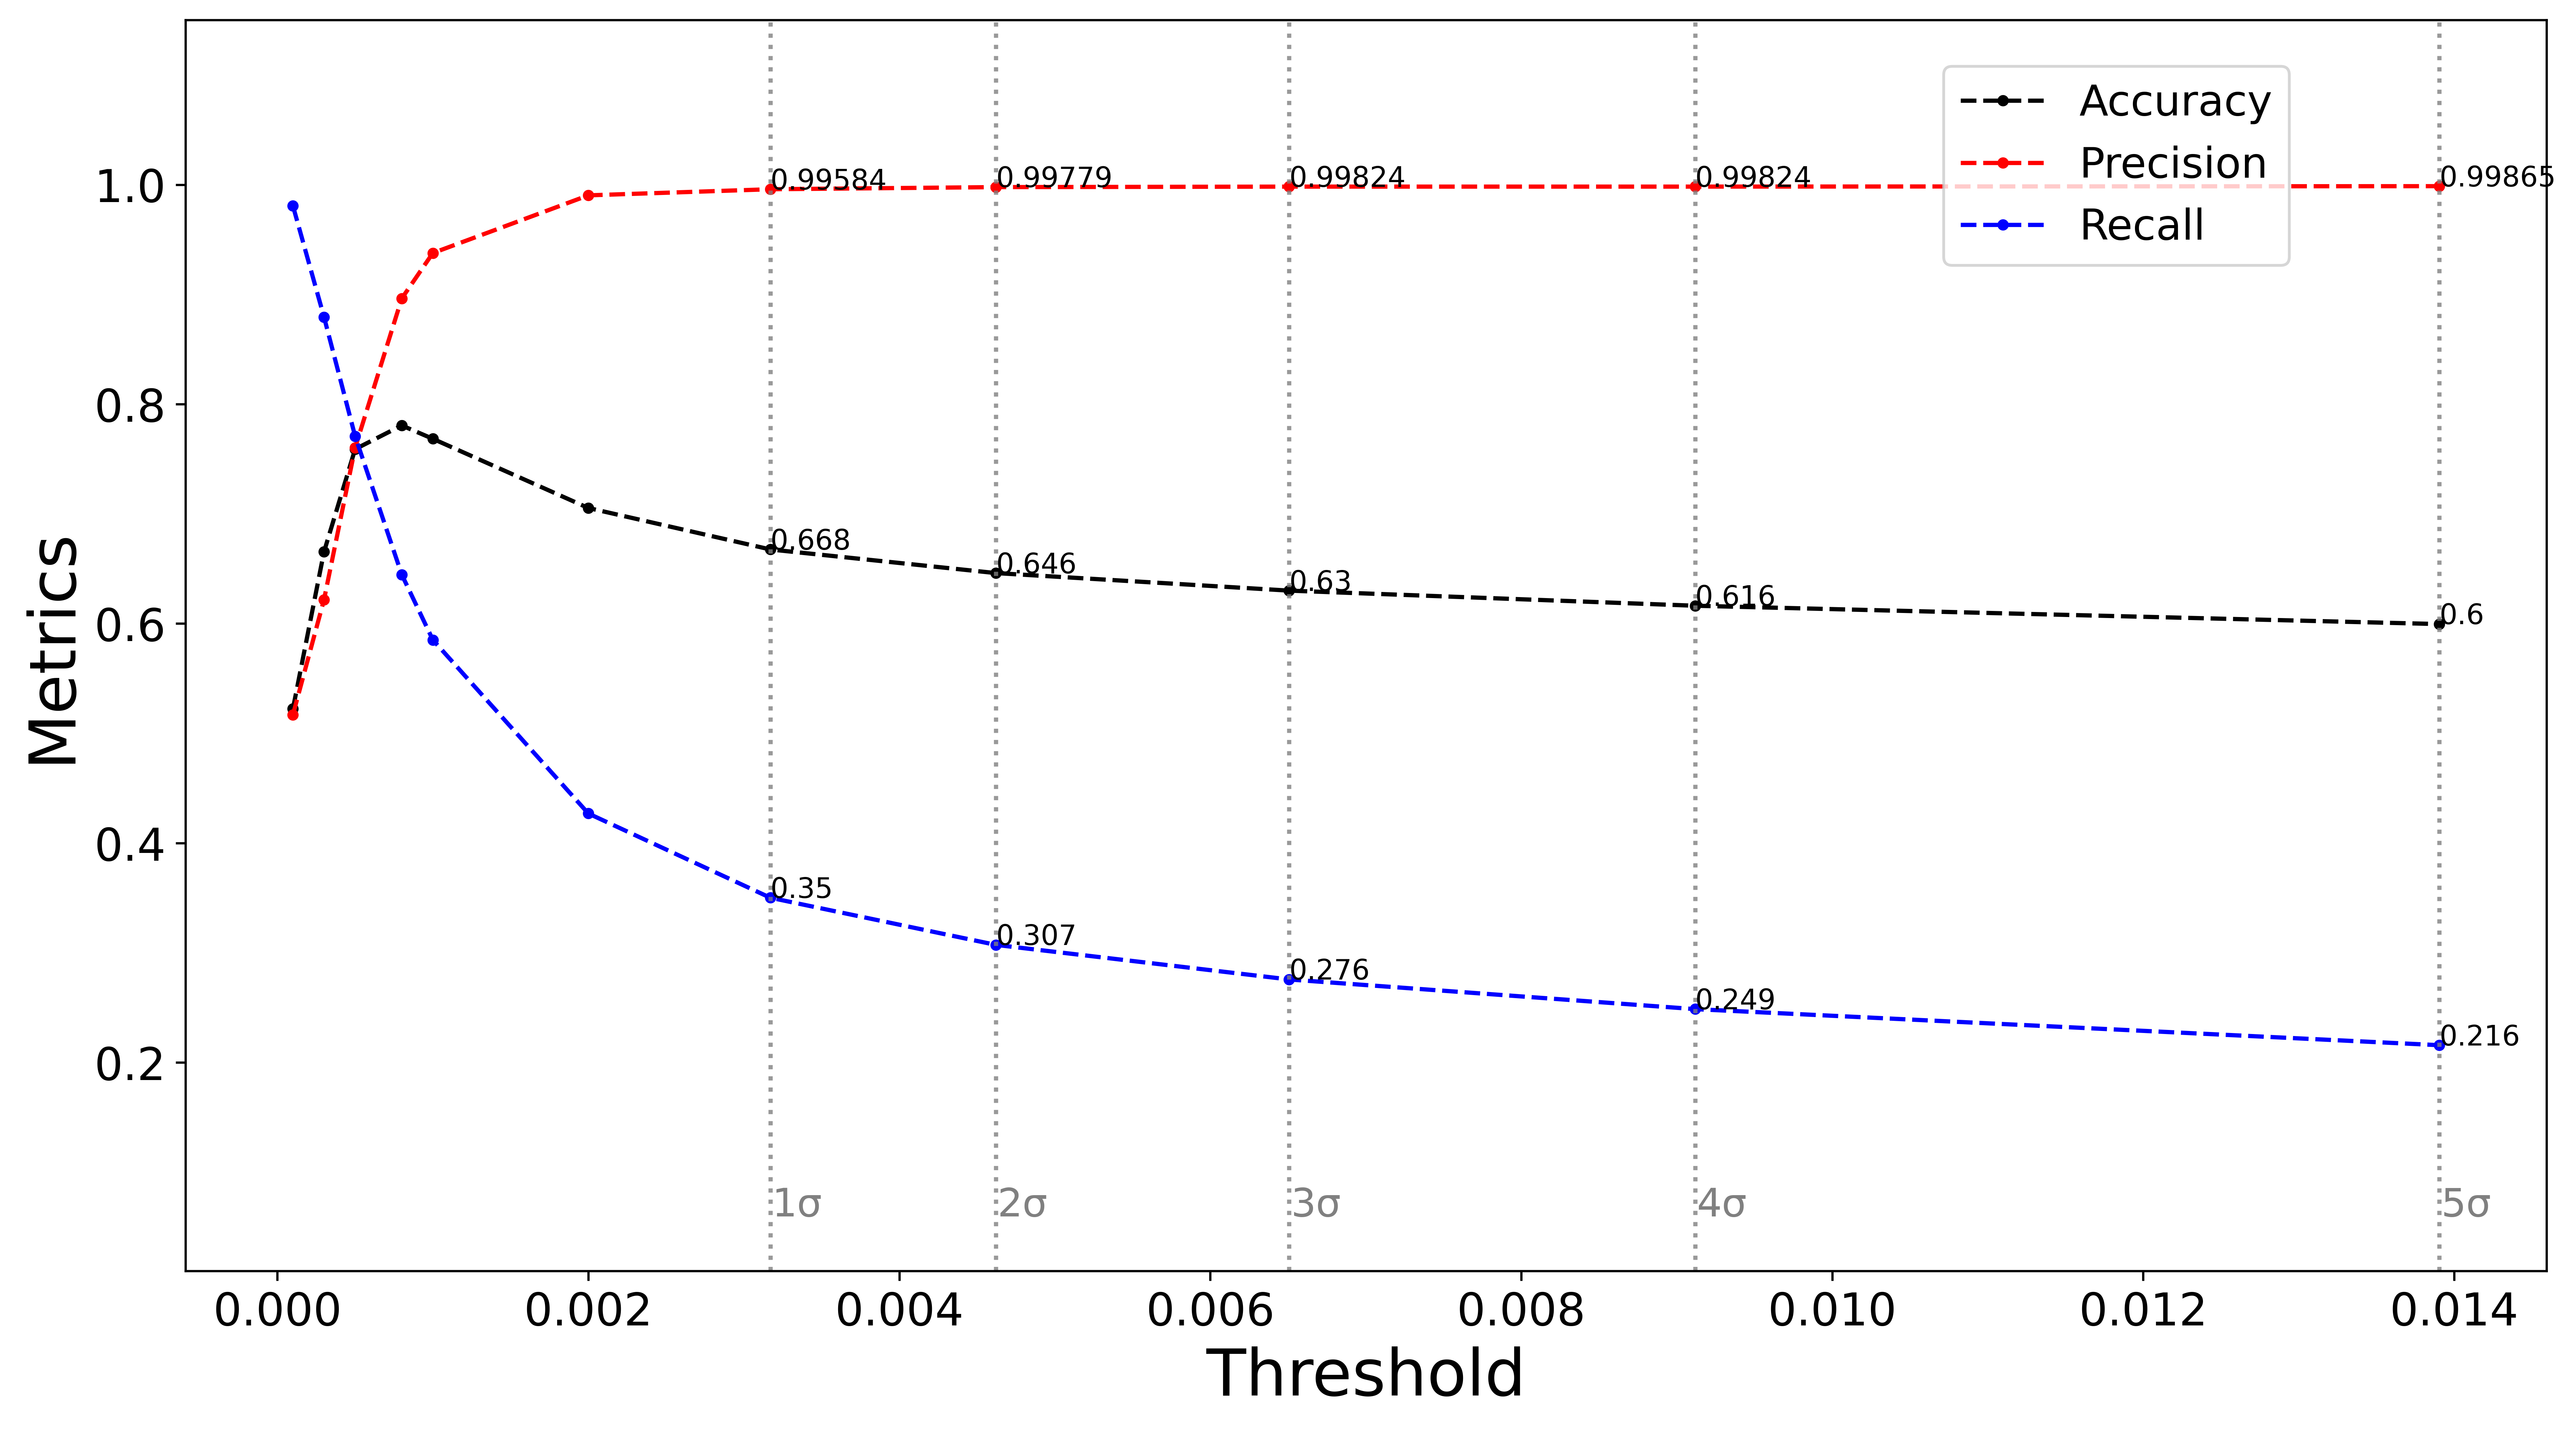

Saved figure to:  logs/test_models_dataset_test_set_all_itime_5/cnn_metrics_test_set_all_itime_5.png


In [30]:
plot_nn_metrics(metrics_cnn, model_config_cnn, output_dir, fig_name="cnn_metrics_test_set_all_itime_5", annotate_after=6, y_lim=(0.01, 1.15), showFig=True, saveFig=True)

## Standard metrics - 5 sigma

In [31]:
SIGMA_THRESHOLD = 5

In [32]:
sigma_threshold = get_threshold_for_sigma(model_config_cnn.pvalue_table, SIGMA_THRESHOLD)
model_config_cnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_cnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_cnn.pvalue_table, model_config_cnn.ad.threshold)} sigma")

Threshold: 0.0139048776129999 corresponding to 5.0465140766 sigma


In [33]:
print(f"************** Evaluating {model_config_cnn.name} patience={model_config_cnn.patience} **************")
metrics = model_config_cnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_cnn.ad.detection_delay(test_all_y, model_config_cnn.ad.predict(test_all_x), test_set_size, model_config_cnn.timesteps))

************** Evaluating AnomalyDetector_cnn_l2_u32 patience=5 **************
Using threshold 0.0139048776129999
accuracy 0.5995922832140016
precision 0.9986477349560514
recall 0.2158199795431299
f1 0.35493431592438324
roc_auc 0.6077576513772116
confusion_matrix [[19687, 6], [16100, 4431]]
false_positive_rate 0.001352265043948614
detection_delay: 2.360381861575179


## Sigma table

In [34]:
data = {}
for template in tqdm(list(data_manager.data.keys())):
    test_x, test_y = data_manager.get_test_set(template=template, onset=250, integration_time=5, sub_window_size=5, stride=1)
    model_config_cnn.ad.predict(test_x)
    data[template] = get_sigma_for_ts_array(model_config_cnn.pvalue_table, model_config_cnn.ad.get_reconstruction_errors(), verbose=False)

sigma_table_cnn = pd.DataFrame(data, index=DataManager.get_tbin_of_sequences(96, 5, 5, 1))    
sigma_table_cnn = sigma_table_cnn.applymap(crop_to_5)
sigma_table_cnn

100%|██████████| 419/419 [00:22<00:00, 18.99it/s]


run0002_ID000044  run0005_ID000225  run0009_ID000191  \
0-25                  0.0                 0                 0   
5-30                  0.0                 0                 0   
10-35                 0.0                 0                 0   
15-40                 0.0                 0                 0   
20-45                 0.0                 0                 0   
...                   ...               ...               ...   
455-480               0.0                 0                 0   
460-485               0.0                 0                 0   
465-490               0.0                 0                 0   
470-495               0.0                 0                 0   
475-500               0.0                 0                 0   

         run0011_ID000139  run0013_ID000321  run0016_ID000340  \
0-25                    0                 0                 0   
5-30                    0                 0                 0   
10-35                   0                 0                 0   
15-40                   0                 0                 0   
20-45                   0                 0                 0   
...                   ...               ...               ...   
455-480                 0                 0                 0   
460-485                 0                 0                 0   
465-490                 0                 0                 0   
470-495                 0                 0                 0   
475-500                 0                 0                 0   

         run0017_ID000132  run0017_ID000261  run0017_ID000302  \
0-25                  0.0          0.000000                 0   
5-30                  0.0          0.000000                 0   
10-35                 0.0          0.000000                 0   
15-40                 0.0          0.000000                 0   
20-45                 0.0          0.000000                 0   
...                   ...               ...               ...   
455-480               0.0          1.993607                 0   
460-485               0.0          2.534140                 0   
465-490               0.0          2.869506                 0   
470-495               0.0          3.109056                 0   
475-500               0.0          1.631926                 0   

         run0019_ID000070  run0019_ID000268  run0019_ID000338  \
0-25              0.00000          0.000000                 0   
5-30              0.00000          0.000000                 0   
10-35             0.00000          0.000000                 0   
15-40             0.00000          0.000000                 0   
20-45             0.00000          0.000000                 0   
...                   ...               ...               ...   
455-480           5.00001          4.868434                 0   
460-485           5.00001          3.882413                 0   
465-490           5.00001          2.832759                 0   
470-495           5.00001          4.750939                 0   
475-500           5.00001          4.569269                 0   

         run0021_ID000373  run0023_ID000267  run0025_ID000471  \
0-25                    0               0.0                 0   
5-30                    0               0.0                 0   
10-35                   0               0.0                 0   
15-40                   0               0.0                 0   
20-45                   0               0.0                 0   
...                   ...               ...               ...   
455-480                 0               0.0                 0   
460-485                 0               0.0                 0   
465-490                 0               0.0                 0   
470-495                 0               0.0                 0   
475-500                 0               0.0                 0   

         run0026_ID000127  run0027_ID000288  run0029_ID000397  \
0-25                    0              

In [35]:
sigma_table_cnn

run0002_ID000044  run0005_ID000225  run0009_ID000191  \
0-25                  0.0                 0                 0   
5-30                  0.0                 0                 0   
10-35                 0.0                 0                 0   
15-40                 0.0                 0                 0   
20-45                 0.0                 0                 0   
...                   ...               ...               ...   
455-480               0.0                 0                 0   
460-485               0.0                 0                 0   
465-490               0.0                 0                 0   
470-495               0.0                 0                 0   
475-500               0.0                 0                 0   

         run0011_ID000139  run0013_ID000321  run0016_ID000340  \
0-25                    0                 0                 0   
5-30                    0                 0                 0   
10-35                   0                 0                 0   
15-40                   0                 0                 0   
20-45                   0                 0                 0   
...                   ...               ...               ...   
455-480                 0                 0                 0   
460-485                 0                 0                 0   
465-490                 0                 0                 0   
470-495                 0                 0                 0   
475-500                 0                 0                 0   

         run0017_ID000132  run0017_ID000261  run0017_ID000302  \
0-25                  0.0          0.000000                 0   
5-30                  0.0          0.000000                 0   
10-35                 0.0          0.000000                 0   
15-40                 0.0          0.000000                 0   
20-45                 0.0          0.000000                 0   
...                   ...               ...               ...   
455-480               0.0          1.993607                 0   
460-485               0.0          2.534140                 0   
465-490               0.0          2.869506                 0   
470-495               0.0          3.109056                 0   
475-500               0.0          1.631926                 0   

         run0019_ID000070  run0019_ID000268  run0019_ID000338  \
0-25              0.00000          0.000000                 0   
5-30              0.00000          0.000000                 0   
10-35             0.00000          0.000000                 0   
15-40             0.00000          0.000000                 0   
20-45             0.00000          0.000000                 0   
...                   ...               ...               ...   
455-480           5.00001          4.868434                 0   
460-485           5.00001          3.882413                 0   
465-490           5.00001          2.832759                 0   
470-495           5.00001          4.750939                 0   
475-500           5.00001          4.569269                 0   

         run0021_ID000373  run0023_ID000267  run0025_ID000471  \
0-25                    0               0.0                 0   
5-30                    0               0.0                 0   
10-35                   0               0.0                 0   
15-40                   0               0.0                 0   
20-45                   0               0.0                 0   
...                   ...               ...               ...   
455-480                 0               0.0                 0   
460-485                 0               0.0                 0   
465-490                 0               0.0                 0   
470-495                 0               0.0                 0   
475-500                 0               0.0                 0   

         run0026_ID000127  run0027_ID000288  run0029_ID000397  \
0-25                    0              

# Li&Ma

In [36]:
li_ma_data = {}
#templates = list(data_manager.data.keys())
#templates = templates[0:10]
templates = []

LiMa_detect_p = partial(LiMa.detect, "binned", integration_time, 99999, sigma_table_rnn.index.values, 500, 0, False, 0.2, [0.03, 1])
start = time()
with multiprocessing.Pool() as p:
    values = p.map(LiMa_detect_p, [DataManager.get_fits_from_template(fits_files, template) for template in templates])

for i, template in enumerate(templates):
     li_ma_data[template] = values[i]["sigma"].values   

print(f"Took {time()-start} s")
    
#
lima_sigma_table = pd.DataFrame(li_ma_data, index=sigma_table_rnn.index.values)
if len(templates) > 0:
    lima_sigma_table.to_csv(Path(output_dir).joinpath("sigma_table_li_ma_test_set_all_itime_5.csv"))    

Took 2.1296749114990234 s


In [37]:
lima_sigma_table = pd.read_csv(Path(output_dir).joinpath("sigma_table_li_ma_test_set_all_itime_5.csv"), index_col=0)

In [38]:
### FIX INDEPENDENCE
for time_bin in lima_sigma_table.index:
    if int(time_bin.split("-")[1])%25 != 0:
        lima_sigma_table.loc[time_bin] = 0
lima_sigma_table

run0002_ID000044  run0005_ID000225  run0009_ID000191  \
0-25             1.191668          0.372436          0.899024   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          0.000000          1.328792          0.537984   

         run0011_ID000139  run0013_ID000321  run0016_ID000340  \
0-25             0.825102          0.000000          0.625965   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          1.283201          1.504661          1.036105   

         run0017_ID000132  run0017_ID000261  run0017_ID000302  \
0-25             0.954083          0.688925          1.504661   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          1.559641          6.587490          0.913353   

         run0019_ID000070  run0019_ID000268  run0019_ID000338  \
0-25             1.702402          0.000000          0.714559   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500         16.770241         10.100573          0.605788   

         run0021_ID000373  run0023_ID000267  run0025_ID000471  \
0-25             1.889054          1.456416          0.146130   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          0.361247          2.781631          1.322373   

         run0026_ID000127  run0027_ID000288  run0029_ID000397  \
0-25             0.444927          1.43

In [39]:
lima_sigma_table = lima_sigma_table.applymap(crop_to_5)
lima_sigma_table

run0002_ID000044  run0005_ID000225  run0009_ID000191  \
0-25             1.191668          0.372436          0.899024   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          0.000000          1.328792          0.537984   

         run0011_ID000139  run0013_ID000321  run0016_ID000340  \
0-25             0.825102          0.000000          0.625965   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          1.283201          1.504661          1.036105   

         run0017_ID000132  run0017_ID000261  run0017_ID000302  \
0-25             0.954083          0.688925          1.504661   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          1.559641          5.000010          0.913353   

         run0019_ID000070  run0019_ID000268  run0019_ID000338  \
0-25             1.702402           0.00000          0.714559   
5-30             0.000000           0.00000          0.000000   
10-35            0.000000           0.00000          0.000000   
15-40            0.000000           0.00000          0.000000   
20-45            0.000000           0.00000          0.000000   
...                   ...               ...               ...   
455-480          0.000000           0.00000          0.000000   
460-485          0.000000           0.00000          0.000000   
465-490          0.000000           0.00000          0.000000   
470-495          0.000000           0.00000          0.000000   
475-500          5.000010           5.00001          0.605788   

         run0021_ID000373  run0023_ID000267  run0025_ID000471  \
0-25             1.889054          1.456416          0.146130   
5-30             0.000000          0.000000          0.000000   
10-35            0.000000          0.000000          0.000000   
15-40            0.000000          0.000000          0.000000   
20-45            0.000000          0.000000          0.000000   
...                   ...               ...               ...   
455-480          0.000000          0.000000          0.000000   
460-485          0.000000          0.000000          0.000000   
465-490          0.000000          0.000000          0.000000   
470-495          0.000000          0.000000          0.000000   
475-500          0.361247          2.781631          1.322373   

         run0026_ID000127  run0027_ID000288  run0029_ID000397  \
0-25             0.444927          1.43

## Results: 5 sigma detections

In [40]:
templates_detections = dotdict({})
for templ_det in lima_sigma_table:
    templates_detections[templ_det] = dotdict({}) 
    templates_detections[templ_det]["li_ma"] = dotdict({})
    templates_detections[templ_det]["cnn"] = dotdict({})
    templates_detections[templ_det]["rnn"] = dotdict({})

In [41]:
for templ_det in lima_sigma_table:
    detections_3s = lima_sigma_table[templ_det] >= 3
    detections_5s = lima_sigma_table[templ_det] >= 5
    templates_detections[templ_det]["li_ma"]["3s_detection"] = detections_3s.any()
    templates_detections[templ_det]["li_ma"]["5s_detection"] = detections_5s.any()
    templates_detections[templ_det]["li_ma"]["3s_detections_indexes"] = np.where(detections_3s == True)[0]
    templates_detections[templ_det]["li_ma"]["5s_detections_indexes"] = np.where(detections_5s == True)[0]

for templ_det in sigma_table_rnn:
    detections_3s = sigma_table_rnn[templ_det] >= 3
    detections_5s = sigma_table_rnn[templ_det] >= 5
    templates_detections[templ_det]["rnn"]["3s_detection"] = detections_3s.any()
    templates_detections[templ_det]["rnn"]["5s_detection"] = detections_5s.any()
    templates_detections[templ_det]["rnn"]["3s_detections_indexes"] = np.where(detections_3s == True)[0]
    templates_detections[templ_det]["rnn"]["5s_detections_indexes"] = np.where(detections_5s == True)[0]
    
for templ_det in sigma_table_cnn:
    detections_3s = sigma_table_cnn[templ_det] >= 3
    detections_5s = sigma_table_cnn[templ_det] >= 5
    templates_detections[templ_det]["cnn"]["3s_detection"] = detections_3s.any()
    templates_detections[templ_det]["cnn"]["5s_detection"] = detections_5s.any()
    templates_detections[templ_det]["cnn"]["3s_detections_indexes"] = np.where(detections_3s == True)[0]
    templates_detections[templ_det]["cnn"]["5s_detections_indexes"] = np.where(detections_5s == True)[0]    

In [42]:
def filter_templates(templates_detections, model, other_model, which, sigma, detection_index_min, detection_index_max):

    templates = []
    
    for template_name, template_result in templates_detections.items():
    
        model_detected       = template_result[model][f"{sigma}s_detection"]
        
        if which == "common":
            other_model_detected = template_result[other_model][f"{sigma}s_detection"]
            if model_detected and other_model_detected:
                model_first_detection_index       = template_result[model][f"{sigma}s_detections_indexes"][0]
                other_model_first_detection_index = template_result[other_model][f"{sigma}s_detections_indexes"][0]
                
                if (model_first_detection_index >= detection_index_min and model_first_detection_index <= detection_index_max) and (other_model_first_detection_index >= detection_index_min and other_model_first_detection_index <= detection_index_max): 
                    templates.append(template_name)

        elif which == "first":
            if model_detected:

                model_first_detection_index = template_result[model][f"{sigma}s_detections_indexes"][0]
                
                if (model_first_detection_index >= detection_index_min and model_first_detection_index <= detection_index_max): 
                    templates.append(template_name)                

                    
        elif which == "first-only":

            other_model_detected = template_result[other_model][f"{sigma}s_detection"]

            if model_detected and (not other_model_detected):

                model_first_detection_index       = template_result[model][f"{sigma}s_detections_indexes"][0]
                
                if (model_first_detection_index >= detection_index_min and model_first_detection_index <= detection_index_max): 
                    templates.append(template_name)                
        

        elif which == "second":
            other_model_detected = template_result[other_model][f"{sigma}s_detection"]
            if other_model_detected:

                other_model_first_detection_index       = template_result[other_model][f"{sigma}s_detections_indexes"][0]
                
                if (other_model_first_detection_index >= detection_index_min and other_model_first_detection_index <= detection_index_max): 
                    templates.append(template_name)                

                    
        elif which == "second-only":
            other_model_detected = template_result[other_model][f"{sigma}s_detection"]
            if (not model_detected) and other_model_detected:

                other_model_first_detection_index       = template_result[other_model][f"{sigma}s_detections_indexes"][0]
                
                if (other_model_first_detection_index >= detection_index_min and other_model_first_detection_index <= detection_index_max): 
                    templates.append(template_name)                
                
        
        
        elif which == "none":
            other_model_detected = template_result[other_model][f"{sigma}s_detection"]
            if (not model_detected) and (not other_model_detected):
                templates.append(template_name)

    
        #model_first_detection_index      = template_result[model][f"{sigma}s_detections_indexes"][0]
        #othermodel_first_detection_index = template_result[other_model][f"{sigma}s_detections_indexes"][0]
    return templates

In [238]:
class IncrementalMean:
    
    def __init__(self):
        self.mean = 0.0
        self.var = 0.0
        self.n = 0
    def update(self, samples):
        for s in samples:
            self.n += 1            
            delta = s - self.mean
            self.mean += delta / self.n
            self.var += delta * (s - self.mean)
                

                
    def __str__(self):
        return f"{round(self.mean,2)} +- {round(self.var/(self.n - 1), 2)}"

def get_new_samples(templates, model, sigma, onset_index, integration_time):
    first_detection_indexes = []
    for template_name in templates:
        first_detection_index = templates_detections[template_name][model][f"{sigma}s_detections_indexes"][0]
        first_detection_indexes.append(first_detection_index)
    first_detection_time_relative_to_tt = (np.array(first_detection_indexes)-onset_index)*integration_time 
    return first_detection_time_relative_to_tt

def get_dd(model, templates_detections, sigma, onset_index, integration_time, tmin, tmaxs):
    
    im_model = IncrementalMean()
    im_model_common_lima = IncrementalMean()
    
    for tmax in tmaxs:
        
        tbin_min=f"{tmin*integration_time}-{tmin*integration_time+integration_time*5}"
        tbin_max=f"{tmax*integration_time}-{tmax*integration_time+integration_time*5}"
        print(f"{tbin_min}=>{tbin_max}")
        
        templates = filter_templates(templates_detections, model, None, "first", sigma, tmin, tmax)
        common_with_lima = filter_templates(templates_detections, model, "li_ma", "common", sigma, tmin, tmax)
        
        new_samples = get_new_samples(templates, model, sigma, onset_index, integration_time)
        im_model.update(new_samples)
        print(f"{model} {im_model}")

        new_samples = get_new_samples(common_with_lima, model, sigma, onset_index, integration_time)
        im_model_common_lima.update(new_samples)
        print(f"{model} {im_model_common_lima} [common LiMa]\n")

In [199]:

def filter_templates(templates_detections, model, other_model, which, sigma, detection_index_min, detection_index_max):

    templates = []
    #print("detection_index_min:",detection_index_min)
    #print("detection_index_max:",detection_index_max)

    for template_name, template_result in templates_detections.items():
    
        model_detected       = template_result[model][f"{sigma}s_detection"]
        
        if which == "common":
            other_model_detected = template_result[other_model][f"{sigma}s_detection"]
            if model_detected and other_model_detected:
                model_first_detection_index       = template_result[model][f"{sigma}s_detections_indexes"][0]
                other_model_first_detection_index = template_result[other_model][f"{sigma}s_detections_indexes"][0]
                
                if (model_first_detection_index >= detection_index_min and model_first_detection_index <= detection_index_max) and (other_model_first_detection_index >= detection_index_min and other_model_first_detection_index <= detection_index_max): 
                    templates.append(template_name)

        elif which == "first":
            if model_detected:

                model_first_detection_index = template_result[model][f"{sigma}s_detections_indexes"][0]
                
                if (model_first_detection_index >= detection_index_min and model_first_detection_index <= detection_index_max): 
                    templates.append(template_name)                

                    
        elif which == "first-only":

            other_model_detected = template_result[other_model][f"{sigma}s_detection"]

            if model_detected and (not other_model_detected):

                model_first_detection_index       = template_result[model][f"{sigma}s_detections_indexes"][0]
                
                if (model_first_detection_index >= detection_index_min and model_first_detection_index <= detection_index_max): 
                    templates.append(template_name)                
        

        elif which == "second":
            other_model_detected = template_result[other_model][f"{sigma}s_detection"]
            if other_model_detected:

                other_model_first_detection_index       = template_result[other_model][f"{sigma}s_detections_indexes"][0]
                
                if (other_model_first_detection_index >= detection_index_min and other_model_first_detection_index <= detection_index_max): 
                    templates.append(template_name)                

                    
        elif which == "second-only":
            other_model_detected = template_result[other_model][f"{sigma}s_detection"]
            if (not model_detected) and other_model_detected:

                other_model_first_detection_index       = template_result[other_model][f"{sigma}s_detections_indexes"][0]
                
                if (other_model_first_detection_index >= detection_index_min and other_model_first_detection_index <= detection_index_max): 
                    templates.append(template_name)                
                
        
        
        elif which == "none":
            other_model_detected = template_result[other_model][f"{sigma}s_detection"]
            if (not model_detected) and (not other_model_detected):
                templates.append(template_name)

    
        #model_first_detection_index      = template_result[model][f"{sigma}s_detections_indexes"][0]
        #othermodel_first_detection_index = template_result[other_model][f"{sigma}s_detections_indexes"][0]
    return templates


In [232]:
def detection_tables(SIGMA, ONSET_INDEX, TMIN, TMAXs):
    

    for TMAX in TMAXs:
        
        print(f"\nFrom {TMIN*integration_time}-{TMIN*integration_time+integration_time*5} TO From {TMAX*integration_time}-{TMAX*integration_time+integration_time*5}")

        rnn = filter_templates(templates_detections, "rnn", None, "first", SIGMA, TMIN, TMAX)
        print("  RNN:",len(rnn))

        cnn = filter_templates(templates_detections, "cnn", None, "first", SIGMA, TMIN, TMAX)
        print("  CNN:",len(cnn))

        lima = filter_templates(templates_detections, "li_ma", None, "first", SIGMA, TMIN, TMAX)
        print("  LI_MA:",len(lima))

        common_rnn_lima = filter_templates(templates_detections, "rnn", "li_ma", "common", SIGMA, TMIN, TMAX)
        print(f"  Common RNN-LI_MA detections: {len(common_rnn_lima)}")
        common_cnn_lima = filter_templates(templates_detections, "cnn", "li_ma", "common", SIGMA, TMIN, TMAX)
        print(f"  Common CNN-LI_MA detections: {len(common_cnn_lima)}")

        rnn_no_cnn = filter_templates(templates_detections, "rnn", "cnn", "first-only", SIGMA, TMIN, TMAX)
        print("  RNN but no CNN",len(rnn_no_cnn))
        rnn_no_lima = filter_templates(templates_detections, "rnn", "li_ma", "first-only", SIGMA, TMIN, TMAX)
        print("  RNN but no LI_MA",len(rnn_no_lima))    

        cnn_no_rnn = filter_templates(templates_detections, "cnn", "rnn", "first-only", SIGMA, TMIN, TMAX)
        print("  CNN but no RNN",len(cnn_no_rnn))
        cnn_no_lima = filter_templates(templates_detections, "cnn", "li_ma", "first-only", SIGMA, TMIN, TMAX)
        print("  CNN but no LI_MA",len(cnn_no_lima))       

        lima_no_rnn = filter_templates(templates_detections, "li_ma", "rnn", "first-only", SIGMA, TMIN, TMAX)
        print("  LI_MA but no RNN",len(lima_no_rnn))
        lima_no_cnn = filter_templates(templates_detections, "li_ma", "cnn", "first-only", SIGMA, TMIN, TMAX)
        print("  LI_MA but no CNN",len(lima_no_cnn))           

# Serendipitous discoveries

In [248]:
%matplotlib inline
from rtapipe.lib.plotting.PlotConfig import PlotConfig
import matplotlib.patches as patches

def cumulative_detections_plot(start, stop, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_rectangle=[], add_verical_lines=[]):

    pc = PlotConfig()
    fig, ax = plt.subplots(1,1,figsize=(15, 12))
    ax.set_ylabel("Cumulative number of 5σ detections")
    
    ax.set_xlabel("Time bin ([s-s])")
    ax.set_title("Serendipitous discoveries")

    ax.step(ad_bins, rnn_det, where="post", marker="*", markersize=3, linewidth=0.5, linestyle="-", label="A.D. (RNN)", color="red", alpha=0.9)
    ax.step(ad_bins, cnn_det, where="post", marker="^", markersize=3, linewidth=0.5, linestyle="-", label="A.D. (CNN)", color="orange", alpha=0.9)
    ax.step(lima_bins, lima_det, where="post", marker="x", markersize=5, linewidth=0.6, linestyle="-", label="Li&Ma", color="black", alpha=0.9)

    xticks_x = [i for i in range(45,96,1)]
    xticks_labels = np.array([f"{i*5}-{i*5+25}" for i in xticks_x])
    ax.set_xticks(xticks_x, xticks_labels, fontsize=17)


    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)

    yticks_y = np.array([i for i in range(0,210,10)])
    yticks_labels = np.array([i for i in range(0,210,10)])
    ax.set_yticks(yticks_y, yticks_labels)
    
    ax.axvline(x = 45, color='black', linestyle="-.", alpha=0.8)    
    
    if len(add_verical_lines) > 0:
        for vertical_line_x in add_verical_lines:
            ax.axvline(x = vertical_line_x, color='grey', linestyle="--", linewidth=0.5, alpha=0.7)    
            ax.annotate('Follow-up start', xy=(vertical_line_x+1, 150), fontsize = 16, xytext = (vertical_line_x+4, 180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')

    if len(add_rectangle) > 0:
        rect = patches.Rectangle(add_rectangle[0], add_rectangle[1], add_rectangle[2], linewidth=0, facecolor="grey", alpha=0.3)
        ax.add_patch(rect)
        ax.annotate('Blind search', xy=(add_rectangle[0][0]+1, add_rectangle[0][1]+150), fontsize = 16, xytext = (add_rectangle[0][0]+4, add_rectangle[0][1]+180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
        
    ax.set_xlim(start, stop)
    ax.set_ylim(-1, 200)

    ax.legend(markerscale=1, loc="best")
    
    fig.tight_layout()
    fig.savefig(Path(output_dir).joinpath(f"serendipitous_discoveries_time_5.svg"), dpi=pc.dpi)
    fig.savefig(Path(output_dir).joinpath(f"serendipitous_discoveries_time_5.png"), dpi=pc.dpi)
    
rnn_det = []
cnn_det = []
lima_det = []
bins = [i for i in range(45,96,1)]
lima_bins = [i for i in range(45,96,5)]

for tmax in bins:
    rnn_det.append(
        len(filter_templates(templates_detections, "rnn", None, "first", SIGMA, 0, tmax))
    )
    cnn_det.append(
        len(filter_templates(templates_detections, "cnn", None, "first", SIGMA, 0, tmax))
    )
for tmax in lima_bins:
    lima_det.append(
        len(filter_templates(templates_detections, "li_ma", None, "first", SIGMA, 0, tmax))
    )
    
cumulative_detections_plot(44, 75, rnn_det, cnn_det, lima_det, bins, lima_bins, add_rectangle=[(45, -1), 2, 201])    

In [250]:
SIGMA = 5
ONSET_INDEX=45
TMIN = 0
TMAX = [47,50,55,60]
detection_tables(SIGMA,ONSET_INDEX,TMIN,TMAX)


From 0-25 TO From 235-260
  RNN: 26
  CNN: 21
  LI_MA: 0
  Common RNN-LI_MA detections: 0
  Common CNN-LI_MA detections: 0
  RNN but no CNN 1
  RNN but no LI_MA 3
  CNN but no RNN 0
  CNN but no LI_MA 0
  LI_MA but no RNN 0
  LI_MA but no CNN 0

From 0-25 TO From 250-275
  RNN: 74
  CNN: 59
  LI_MA: 82
  Common RNN-LI_MA detections: 67
  Common CNN-LI_MA detections: 57
  RNN but no CNN 1
  RNN but no LI_MA 3
  CNN but no RNN 0
  CNN but no LI_MA 2
  LI_MA but no RNN 11
  LI_MA but no CNN 13

From 0-25 TO From 275-300
  RNN: 106
  CNN: 92
  LI_MA: 137
  Common RNN-LI_MA detections: 102
  Common CNN-LI_MA detections: 90
  RNN but no CNN 2
  RNN but no LI_MA 3
  CNN but no RNN 0
  CNN but no LI_MA 2
  LI_MA but no RNN 18
  LI_MA but no CNN 25

From 0-25 TO From 300-325
  RNN: 122
  CNN: 107
  LI_MA: 156
  Common RNN-LI_MA detections: 119
  Common CNN-LI_MA detections: 105
  RNN but no CNN 4
  RNN but no LI_MA 3
  CNN but no RNN 0
  CNN but no LI_MA 2
  LI_MA but no RNN 20
  LI_MA but no 

In [251]:
get_dd("rnn", templates_detections, 5, ONSET_INDEX, 5, ONSET_INDEX, [47,50,55,60])
get_dd("cnn", templates_detections, 5, ONSET_INDEX, 5, ONSET_INDEX, [47,50,55,60])
get_dd("li_ma", templates_detections, 5, ONSET_INDEX, 5, ONSET_INDEX, [47,50,55,60])

225-250=>235-260
rnn 8.27 +- 5.88
rnn 0.0 +- -0.0 [common LiMa]

225-250=>250-275
rnn 13.7 +- 43.75
rnn 15.45 +- 40.71 [common LiMa]

225-250=>275-300
rnn 17.82 +- 103.74
rnn 19.29 +- 98.9 [common LiMa]

225-250=>300-325
rnn 21.23 +- 198.85
rnn 22.67 +- 200.32 [common LiMa]

225-250=>235-260
cnn 8.57 +- 5.36
cnn 0.0 +- -0.0 [common LiMa]

225-250=>250-275
cnn 13.56 +- 40.0
cnn 15.18 +- 40.15 [common LiMa]

225-250=>275-300
cnn 19.16 +- 140.37
cnn 20.65 +- 144.61 [common LiMa]

225-250=>300-325
cnn 23.19 +- 248.78
cnn 24.48 +- 254.71 [common LiMa]

225-250=>235-260
li_ma 0.0 +- -0.0
li_ma 0.0 +- -0.0 [common LiMa]

225-250=>250-275
li_ma 25.0 +- 0.0
li_ma 25.0 +- 0.0 [common LiMa]

225-250=>275-300
li_ma 31.28 +- 118.08
li_ma 31.28 +- 118.08 [common LiMa]

225-250=>300-325
li_ma 34.87 +- 213.22
li_ma 34.87 +- 213.22 [common LiMa]



# Follow-up observations

In [113]:
%matplotlib inline
from rtapipe.lib.plotting.PlotConfig import PlotConfig
import matplotlib.patches as patches

def compute_number_of_detections(tstart):
    rnn_det = []
    cnn_det = []
    lima_det = []
    bins = [i for i in range(tstart,96,1)]
    lima_bins = [i for i in range(tstart,96,5)]

    for tmax in bins:
        rnn_det.append(
            len(filter_templates(templates_detections, "rnn", None, "first", SIGMA, 0, tmax))
        )
        cnn_det.append(
            len(filter_templates(templates_detections, "cnn", None, "first", SIGMA, 0, tmax))
        )
    for tmax in lima_bins:
        lima_det.append(
            len(filter_templates(templates_detections, "li_ma", None, "first", SIGMA, 0, tmax))
        )
    return rnn_det, cnn_det, lima_det, bins, lima_bins


def follow_up_subplot(ax, start, stop, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_rectangle=[], add_verical_lines=[]):

    ax.set_ylabel("Cumulative number of 5σ detections", fontsize=17)
    ax.set_xlabel("Time bin ([s-s])", fontsize=17)

    ax.step(ad_bins, rnn_det, where="post", marker="*", markersize=3, linewidth=0.5, linestyle="-", label="A.D. (RNN)", color="red", alpha=0.9)
    ax.step(ad_bins, cnn_det, where="post", marker="^", markersize=3, linewidth=0.5, linestyle="-", label="A.D. (CNN)", color="orange", alpha=0.9)
    ax.step(lima_bins, lima_det, where="post", marker="x", markersize=5, linewidth=0.6, linestyle="-", label="Li&Ma", color="black", alpha=0.9)

    xticks_x = [i for i in range(45,96,1)]
    xticks_labels = np.array([f"{i*5}-{i*5+25}" for i in xticks_x])
    ax.set_xticks(xticks_x, xticks_labels, fontsize=12)


    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)

    yticks_y = np.array([i for i in range(0,210,10)])
    yticks_labels = np.array([i for i in range(0,210,10)])
    ax.set_yticks(yticks_y, yticks_labels)
    
    ax.axvline(x = 45, color='black', linestyle="-.", alpha=0.8)    
    
    if len(add_verical_lines) > 0:
        for vertical_line_x in add_verical_lines:
            ax.axvline(x = vertical_line_x-5, color='black', linestyle="--", linewidth=1.5, alpha=0.3)
            ax.axvline(x = vertical_line_x, color='grey', linestyle="--", linewidth=1, alpha=0.3)  
            if start < 60:
                ax.annotate('Follow-up start', xy=(vertical_line_x-5+1, 150), fontsize = 16, xytext = (vertical_line_x-5+4, 180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
            else:
                ax.annotate('Follow-up start', xy=(vertical_line_x-5+1, 50), fontsize = 16, xytext = (vertical_line_x-5+4, 80), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
                
    if len(add_rectangle) > 0:
        rect = patches.Rectangle(add_rectangle[0], add_rectangle[1], add_rectangle[2], linewidth=0, facecolor="grey", alpha=0.3)
        ax.add_patch(rect)
        ax.annotate('Blind search', xy=(add_rectangle[0][0]+1, add_rectangle[0][1]+150), fontsize = 16, xytext = (add_rectangle[0][0]+4, add_rectangle[0][1]+180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
        
    ax.set_xlim(44, stop)
    ax.set_ylim(-1, 200)

    if start < 60:
        ax.legend(markerscale=1, loc="lower right", prop={'size': 17})
    else:
        ax.legend(markerscale=1, loc="lower left", prop={'size': 17})
        
    return ax

def follow_up_plot(tstarts):
    pc = PlotConfig()
    fig, axes = plt.subplots(2,2,figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle("Follow-up observations")
    
    axes = axes.flatten()
    for idx, tstart in enumerate(tstarts):
        rnn_det, cnn_det, lima_det, ad_bins, lima_bins = compute_number_of_detections(tstart)
        axes[idx] = follow_up_subplot(axes[idx], tstart, 85, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_verical_lines=[tstart])
    fig.tight_layout()
    
    fig.savefig(Path(output_dir).joinpath(f"follow_up_itime_5.svg"), dpi=pc.dpi)
    fig.savefig(Path(output_dir).joinpath(f"follow_up_itime_5.png"), dpi=pc.dpi)
        
follow_up_plot([55, 60, 65, 70])

In [236]:
SIGMA = 5
ONSET_INDEX=45

detection_tables(SIGMA,ONSET_INDEX,55,[60])
detection_tables(SIGMA,ONSET_INDEX,60,[65])
detection_tables(SIGMA,ONSET_INDEX,65,[70])
detection_tables(SIGMA,ONSET_INDEX,70,[75])


From 275-300 TO From 300-325
  RNN: 17
  CNN: 21
  LI_MA: 74
  Common RNN-LI_MA detections: 16
  Common CNN-LI_MA detections: 19
  RNN but no CNN 2
  RNN but no LI_MA 0
  CNN but no RNN 0
  CNN but no LI_MA 0
  LI_MA but no RNN 9
  LI_MA but no CNN 17

From 300-325 TO From 325-350
  RNN: 10
  CNN: 10
  LI_MA: 30
  Common RNN-LI_MA detections: 8
  Common CNN-LI_MA detections: 6
  RNN but no CNN 1
  RNN but no LI_MA 0
  CNN but no RNN 0
  CNN but no LI_MA 0
  LI_MA but no RNN 10
  LI_MA but no CNN 14

From 325-350 TO From 350-375
  RNN: 4
  CNN: 5
  LI_MA: 15
  Common RNN-LI_MA detections: 0
  Common CNN-LI_MA detections: 0
  RNN but no CNN 0
  RNN but no LI_MA 0
  CNN but no RNN 0
  CNN but no LI_MA 0
  LI_MA but no RNN 11
  LI_MA but no CNN 13

From 350-375 TO From 375-400
  RNN: 4
  CNN: 6
  LI_MA: 9
  Common RNN-LI_MA detections: 1
  Common CNN-LI_MA detections: 0
  RNN but no CNN 2
  RNN but no LI_MA 0
  CNN but no RNN 0
  CNN but no LI_MA 0
  LI_MA but no RNN 7
  LI_MA but no CNN 

In [240]:
get_dd("rnn", templates_detections, 5, ONSET_INDEX, 5, 55,[60])
get_dd("cnn", templates_detections, 5, ONSET_INDEX, 5, 55,[60])
get_dd("li_ma", templates_detections, 5, ONSET_INDEX, 5, 55,[60])

275-300=>300-325
rnn 61.47 +- 61.76
rnn 60.94 +- 60.73 [common LiMa]

275-300=>300-325
cnn 60.24 +- 81.19
cnn 60.79 +- 84.06 [common LiMa]

275-300=>300-325
li_ma 56.42 +- 120.9
li_ma 56.42 +- 120.9 [common LiMa]



In [241]:
get_dd("rnn", templates_detections, 5, ONSET_INDEX, 5,60,[65])
get_dd("cnn", templates_detections, 5, ONSET_INDEX, 5,60,[65])
get_dd("li_ma", templates_detections, 5, ONSET_INDEX, 5,60,[65])

300-325=>325-350
rnn 86.0 +- 71.11
rnn 84.37 +- 60.27 [common LiMa]

300-325=>325-350
cnn 85.5 +- 74.72
cnn 90.0 +- 60.0 [common LiMa]

300-325=>325-350
li_ma 84.17 +- 150.14
li_ma 84.17 +- 150.14 [common LiMa]



In [244]:
get_dd("rnn", templates_detections, 5, ONSET_INDEX, 5,65,[70])
get_dd("cnn", templates_detections, 5, ONSET_INDEX, 5,65,[70])
get_dd("li_ma", templates_detections, 5, ONSET_INDEX, 5,65,[70])

325-350=>350-375
rnn 111.25 +- 122.92
rnn 0.0 +- -0.0 [common LiMa]

325-350=>350-375
cnn 114.0 +- 42.5
cnn 0.0 +- -0.0 [common LiMa]

325-350=>350-375
li_ma 106.67 +- 130.95
li_ma 106.67 +- 130.95 [common LiMa]



In [246]:
get_dd("rnn", templates_detections, 5, ONSET_INDEX, 5,70,[75])
get_dd("cnn", templates_detections, 5, ONSET_INDEX, 5,70,[75])
get_dd("li_ma", templates_detections, 5, ONSET_INDEX, 5,70,[75])

350-375=>375-400
rnn 138.75 +- 89.58
rnn 145.0 +- nan [common LiMa]

350-375=>375-400
cnn 138.33 +- 106.67
cnn 0.0 +- -0.0 [common LiMa]

350-375=>375-400
li_ma 138.89 +- 173.61
li_ma 138.89 +- 173.61 [common LiMa]



/tmp/ipykernel_220255/1980975851.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return f"{round(self.mean,2)} +- {round(self.var/(self.n - 1), 2)}"


# Sigma plots RNN vs Li&Ma

In [ ]:
%matplotlib inline
from rtapipe.lib.plotting.PlotConfig import PlotConfig

def sigma_plot(template, sigma_table_model, lima_sigma_table):
    pc = PlotConfig()    
    fig, ax = plt.subplots(1,1, figsize=pc.fig_size)
    ax.plot(sigma_table_model.index.values, sigma_table_model[template], marker='o', linestyle='--', label="Anomaly Detection", zorder=1)
    

    cumulative_li_ma_reduced = []
    bins_li_ma_reduced = []
    for i in range(10, 100, 5):
        if i % 5 == 0:
            cumulative_li_ma_reduced.append(lima_sigma_table[template][i])
            bins_li_ma_reduced.append(sigma_table_model.index.values[i])

    ax.scatter(bins_li_ma_reduced, cumulative_li_ma_reduced, marker='x', s=200, label="Li&Ma", color="grey", zorder=10)
    ax.tick_params(axis='y', labelsize=15, width=2, grid_alpha=0.5)
    ax.tick_params(axis='x', which='major', labelsize=10)
    fig.suptitle("Detection plot")
    ax.set_title(f"Template {template}")
    ax.set_ylabel("Sigma")
    ax.set_xlabel("Timeseries")
    ax.set_ylim(0, 10)
    plt.axvline(x = 45, color = 'grey', linestyle="-.")
    plt.axhline(y = 3, color = 'orange', linestyle="-.")
    plt.axhline(y = 5, color = 'red', linestyle="-.")
    mask = [True if i%2==0 else False for i in range(len(sigma_table_model.index.values))]
    ax.set_xticks(range(0, len(sigma_table_model.index.values), 2), sigma_table_model.index.values[mask], rotation=45)
    ax.legend()
    outputdir = Path(output_dir).joinpath("detection_plots")
    outputdir.mkdir(exist_ok=True)    
    fig.savefig(outputdir.joinpath(f"detection_plot_{template}_test_set_all_itime_5.png"), dpi=100)
    #plt.show()    
    plt.close()
templates = list(data_manager.data.keys())
    
for template in tqdm(templates):
    sigma_plot(template, sigma_table_rnn, lima_sigma_table)